In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## 1. Load Datasets

In [2]:
# main train and test datasets
columns = ['user_id', 'item_id', 'rating', 'timestamp']
train_df = pd.read_csv('data/ua.train', sep='\t', names=columns)
test_df = pd.read_csv('data/ua.test', sep='\t', names=columns)

# item information
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + [f'genre_{i}' for i in range(19)]
items_df = pd.read_csv('data/u.item', sep='|', names=item_columns, encoding='latin-1')

# genre names for readability
genres_df = pd.read_csv('data/u.genre', sep='|', names=['genre', 'genre_id'])
genre_mapping = dict(zip(genres_df['genre_id'], genres_df['genre']))

for i in range(len(genres_df)):
    old_name = f'genre_{i}'
    new_name = genre_mapping[i]
    items_df = items_df.rename(columns={old_name: new_name})
    
    
# user information
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)

# combine dataframes
train_df = train_df.merge(items_df, left_on='item_id', right_on='movie_id')
train_df = train_df.merge(users_df, on='user_id')

test_df = test_df.merge(items_df, left_on='item_id', right_on='movie_id')
test_df = test_df.merge(users_df, on='user_id')

In [3]:
items_df.head(15)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
print(train_df.shape)
print(test_df.shape)

(90570, 32)
(9430, 32)


In [5]:
train_df.head(15)

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
1,1,2,3,876893171,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,...,0,0,0,1,0,0,24,M,technician,85711
2,1,3,4,878542960,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,...,0,0,0,1,0,0,24,M,technician,85711
3,1,4,3,876893119,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,...,0,0,0,0,0,0,24,M,technician,85711
4,1,5,3,889751712,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,...,0,0,0,1,0,0,24,M,technician,85711
5,1,6,5,887431973,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,...,0,0,0,0,0,0,24,M,technician,85711
6,1,7,4,875071561,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,...,0,0,1,0,0,0,24,M,technician,85711
7,1,8,1,875072484,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,...,0,0,0,0,0,0,24,M,technician,85711
8,1,9,5,878543541,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,...,0,0,0,0,0,0,24,M,technician,85711
9,1,10,3,875693118,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,...,0,0,0,0,1,0,24,M,technician,85711


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             90570 non-null  int64  
 1   item_id             90570 non-null  int64  
 2   rating              90570 non-null  int64  
 3   timestamp           90570 non-null  int64  
 4   movie_id            90570 non-null  int64  
 5   movie_title         90570 non-null  object 
 6   release_date        90562 non-null  object 
 7   video_release_date  0 non-null      float64
 8   imdb_url            90558 non-null  object 
 9   unknown             90570 non-null  int64  
 10  Action              90570 non-null  int64  
 11  Adventure           90570 non-null  int64  
 12  Animation           90570 non-null  int64  
 13  Children's          90570 non-null  int64  
 14  Comedy              90570 non-null  int64  
 15  Crime               90570 non-null  int64  
 16  Docu

## 2. Data cleaning

In [7]:
train_df.describe()

,user_id,item_id,rating,timestamp,movie_id,video_release_date,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
count,90570.000000,90570.000000,90570.000000,9.057000e+04,90570.000000,0.0,90570.000000,90570.000000,90570.000000,90570.000000,...,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000
mean,461.494038,428.104891,3.523827,8.835073e+08,428.104891,NaN,0.000099,0.255316,0.138103,0.036745,...,0.017423,0.053450,0.050348,0.051187,0.193364,0.126830,0.216054,0.093508,0.019079,32.857182
std,266.004364,333.088029,1.126073,5.341684e+06,333.088029,NaN,0.009968,0.436041,0.345010,0.188136,...,0.130842,0.224931,0.218663,0.220380,0.394938,0.332784,0.411554,0.291144,0.136804,11.489888
min,1.000000,1.000000,1.000000,8.747247e+08,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,256.000000,174.000000,3.000000,8.794484e+08,174.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
50%,442.000000,324.000000,4.000000,8.828143e+08,324.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,682.000000,636.000000,4.000000,8.882049e+08,636.000000,NaN,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000
max,943.000000,1682.000000,5.000000,8.932866e+08,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.000000


In [8]:
numeric_columns = train_df.select_dtypes(include=['number']).columns
correlation = train_df[numeric_columns].corr()
correlation_styled = correlation.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format("{:.2f}")
correlation_styled

,user_id,item_id,rating,timestamp,movie_id,video_release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
user_id,1.00,0.01,-0.01,0.02,0.01,nan,-0.01,0.02,0.02,0.01,0.01,-0.01,-0.00,-0.01,-0.00,0.00,0.00,-0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.00,-0.08
item_id,0.01,1.00,-0.19,0.04,1.00,nan,-0.00,-0.15,-0.08,-0.03,-0.01,0.02,-0.10,0.06,0.01,0.04,0.02,-0.01,-0.02,0.01,-0.01,-0.17,-0.05,-0.11,-0.02,-0.01
rating,-0.01,-0.19,1.00,-0.01,-0.19,nan,-0.00,-0.03,-0.01,0.01,-0.04,-0.08,0.03,0.01,0.11,-0.03,0.05,-0.05,0.00,0.02,0.04,0.01,-0.01,0.08,0.01,0.06
timestamp,0.02,0.04,-0.01,1.00,0.04,nan,-0.01,-0.01,-0.02,-0.02,-0.01,-0.02,0.00,0.00,0.03,-0.01,0.01,0.00,-0.00,0.03,0.01,-0.02,-0.00,-0.00,0.00,0.16
movie_id,0.01,1.00,-0.19,0.04,1.00,nan,-0.00,-0.15,-0.08,-0.03,-0.01,0.02,-0.10,0.06,0.01,0.04,0.02,-0.01,-0.02,0.01,-0.01,-0.17,-0.05,-0.11,-0.02,-0.01
video_release_date,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
unknown,-0.01,-0.00,-0.00,-0.01,-0.00,nan,1.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.01
Action,0.02,-0.15,-0.03,-0.01,-0.15,nan,-0.01,1.00,0.45,-0.10,-0.14,-0.22,0.01,-0.05,-0.27,-0.01,-0.08,-0.01,-0.09,-0.03,-0.02,0.32,0.25,0.16,0.06,-0.07
Adventure,0.02,-0.08,-0.01,-0.02,-0.08,nan,-0.00,0.45,1.00,-0.02,0.10,-0.11,-0.03,-0.03,-0.22,0.09,-0.05,-0.06,-0.03,-0.04,-0.02,0.29,-0.05,0.08,0.01,-0.03
Animation,0.01,-0.03,0.01,-0.02,-0.03,nan,-0.00,-0.10,-0.02,1.00,0.56,0.03,-0.06,-0.02,-0.16,0.03,-0.03,-0.03,0.42,-0.05,-0.09,-0.04,-0.08,-0.06,-0.03,-0.03


### Drop uncessary features

Drop item_id since it's perfectly correlated to movie_id;

Drop timestamp since it's not interpretable;

Drop user_id, movie_id, imdb_url since they are not useful in classifying like/dislike;

Drop video_release_date since it's null;

Drop zipcode since it's hard to manipulate and is unlikely to affect movie rating;

Drop unknown since it has no variance.

In [9]:
train_df.drop(['user_id','timestamp','item_id', 'movie_id', 'video_release_date','unknown','imdb_url','zip_code'], axis=1, inplace=True)
test_df.drop(['user_id','timestamp','item_id','movie_id','video_release_date','unknown','imdb_url','zip_code'], axis=1, inplace=True)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        90570 non-null  int64 
 1   movie_title   90570 non-null  object
 2   release_date  90562 non-null  object
 3   Action        90570 non-null  int64 
 4   Adventure     90570 non-null  int64 
 5   Animation     90570 non-null  int64 
 6   Children's    90570 non-null  int64 
 7   Comedy        90570 non-null  int64 
 8   Crime         90570 non-null  int64 
 9   Documentary   90570 non-null  int64 
 10  Drama         90570 non-null  int64 
 11  Fantasy       90570 non-null  int64 
 12  Film-Noir     90570 non-null  int64 
 13  Horror        90570 non-null  int64 
 14  Musical       90570 non-null  int64 
 15  Mystery       90570 non-null  int64 
 16  Romance       90570 non-null  int64 
 17  Sci-Fi        90570 non-null  int64 
 18  Thriller      90570 non-null  int64 
 19  War 

## 3. Feature engineering

In [11]:
# like & dislike (binary target variable)
train_df['like_dislike'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
test_df['like_dislike'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# one-hot encoding 'gender', 'occupation'
train_df = pd.get_dummies(train_df, columns=['gender', 'occupation'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['gender', 'occupation'], drop_first=True)

# convert release date to datetime
train_df['release_date'] = pd.to_datetime(train_df['release_date'], format='%d-%b-%Y', errors='coerce')
train_df['release_year'] = 1998 - train_df['release_date'].dt.year

test_df['release_date'] = pd.to_datetime(test_df['release_date'], format='%d-%b-%Y', errors='coerce')
test_df['release_year'] = 1998 - test_df['release_date'].dt.year

# standardise user age
scaler_age = StandardScaler()

train_df['age'] = scaler_age.fit_transform(train_df[['age']])
test_df['age'] = scaler_age.transform(test_df[['age']]) 

import pandas as pd

# Calculate average rating per movie
popularity = train_df.groupby('movie_title')['rating'].mean()

# Merge the average rating (popularity) back to the original DataFrame
train_df = train_df.merge(popularity.rename('popularity'), on='movie_title', how='left')
test_df = test_df.merge(popularity.rename('popularity'), on='movie_title', how='left')


In [12]:
train_df.head(15)

,rating,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year,popularity
0,5,Toy Story (1995),1995-01-01,0,0,1,1,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.859694
1,3,GoldenEye (1995),1995-01-01,1,1,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.198347
2,4,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.058824
3,3,Get Shorty (1995),1995-01-01,1,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.545455
4,3,Copycat (1995),1995-01-01,0,0,0,0,0,1,0,...,False,False,False,False,False,False,True,False,3.0,3.291139
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.434783
6,4,Twelve Monkeys (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.803468
7,1,Babe (1995),1995-01-01,0,0,0,1,1,0,0,...,False,False,False,False,False,False,True,False,3.0,4.025773
8,5,Dead Man Walking (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.876866
9,3,Richard III (1995),1996-01-22,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,2.0,3.829268


In [13]:
train_df.head()

,rating,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year,popularity
0,5,Toy Story (1995),1995-01-01,0,0,1,1,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.859694
1,3,GoldenEye (1995),1995-01-01,1,1,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.198347
2,4,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.058824
3,3,Get Shorty (1995),1995-01-01,1,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.545455
4,3,Copycat (1995),1995-01-01,0,0,0,0,0,1,0,...,False,False,False,False,False,False,True,False,3.0,3.291139


In [14]:
train_df.drop(['rating','release_date','movie_title'], axis=1, inplace=True)
test_df.drop(['rating','release_date','movie_title'], axis=1, inplace=True)

In [15]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90562 entries, 0 to 90569
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    90562 non-null  int64  
 1   Adventure                 90562 non-null  int64  
 2   Animation                 90562 non-null  int64  
 3   Children's                90562 non-null  int64  
 4   Comedy                    90562 non-null  int64  
 5   Crime                     90562 non-null  int64  
 6   Documentary               90562 non-null  int64  
 7   Drama                     90562 non-null  int64  
 8   Fantasy                   90562 non-null  int64  
 9   Film-Noir                 90562 non-null  int64  
 10  Horror                    90562 non-null  int64  
 11  Musical                   90562 non-null  int64  
 12  Mystery                   90562 non-null  int64  
 13  Romance                   90562 non-null  int64  
 14  Sci-Fi     

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9427 entries, 0 to 9429
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    9427 non-null   int64  
 1   Adventure                 9427 non-null   int64  
 2   Animation                 9427 non-null   int64  
 3   Children's                9427 non-null   int64  
 4   Comedy                    9427 non-null   int64  
 5   Crime                     9427 non-null   int64  
 6   Documentary               9427 non-null   int64  
 7   Drama                     9427 non-null   int64  
 8   Fantasy                   9427 non-null   int64  
 9   Film-Noir                 9427 non-null   int64  
 10  Horror                    9427 non-null   int64  
 11  Musical                   9427 non-null   int64  
 12  Mystery                   9427 non-null   int64  
 13  Romance                   9427 non-null   int64  
 14  Sci-Fi       

In [18]:
train_df.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,like_dislike,release_year,popularity
count,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,...,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000
mean,0.255339,0.138115,0.036748,0.072525,0.300093,0.080155,0.007575,0.397639,0.013736,0.017425,...,0.051191,0.193381,0.126841,0.216073,0.093516,0.019081,0.000051,0.551026,10.234767,3.523840
std,0.436054,0.345023,0.188144,0.259356,0.458301,0.271535,0.086704,0.489413,0.116395,0.130848,...,0.220389,0.394952,0.332797,0.411567,0.291156,0.136810,1.000027,0.497392,14.250570,0.523635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.250442,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.770872,0.000000,2.000000,3.193548
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.248671,1.000000,4.000000,3.594203
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621665,1.000000,12.000000,3.898305
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.493771,1.000000,76.000000,5.000000


In [19]:
train_df.head(15)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year,popularity
0,0,0,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.859694
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.198347
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,3.0,3.058824
3,1,0,0,0,1,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.545455
4,0,0,0,0,0,1,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.291139
5,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.434783
6,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.803468
7,0,0,0,1,1,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,4.025773
8,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,3.0,3.876866
9,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,True,False,2.0,3.829268


## 4. Multi Layer Perceptron model

In [20]:
def validation(model, test_loader, criterion):
    model.eval() 
    # Initialize variables to keep track of the number of examples, accumulated loss, and accumulated accuracy.
    num, acc_loss, acc_acc = 0, 0, 0

    # Iterate through the test loader to evaluate the model on the test data.
    for data, target in test_loader:
        num += 1
        
        # Forward pass: Compute predictions from the model.
        pred = model(data)
        
        # Calculate the loss between the predictions and the target labels.
        loss = criterion(pred, target.view(-1, 1))
        
        # Calculate accuracy by comparing predicted values with the target labels.
        acc = (torch.sigmoid(pred).round().view(-1) == target).float().mean()
        
        # Accumulate loss and accuracy values for later averaging.
        acc_loss += loss.item()
        acc_acc += acc.item()
    
    # Calculate the average loss and accuracy across all batches in the test data.
    avg_loss = acc_loss / num
    avg_acc = acc_acc / num
    
    return avg_loss, avg_acc

In [21]:
class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        
        # Define the layers of the MLP
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),  # Input layer size should match num_features
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer with 50% dropout rate
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # Single output neuron for binary classification
        )

    def forward(self, x):
        return self.classifier(x)  # Output logits for BCEWithLogitsLoss


In [24]:
def train_model(model, train_loader, valid_loader, lr, bz, num_epoch, optim='Adam', verbose=True, print_freq=10):
    # Set up directory to save model checkpoints
    dir = 'model_' + model.__class__.__name__ + '/'
    if not os.path.exists(dir):
        os.makedirs(dir)

    # # Define the loss function
    # criterion = nn.BCEWithLogitsLoss()
    # Calculate the weight for the minority class (Dislike)
    pos_weight = torch.tensor([len(train_df[train_df['like_dislike'] == 0]) / len(train_df[train_df['like_dislike'] == 1])])
    # Define the loss with class weight for balancing
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


     # Select the optimizer (Adam or SGD)
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
    # Initialize tracking for best model based on validation loss
    best_loss, best_test_acc = float('inf'), 0.0

    # Training loop
    losses = []
    for epoch in range(num_epoch):
        model.train()  # Set model to training mode
        acc_loss, acc_acc, num_batches = 0, 0, 0

        for data, target in train_loader:
            num_batches += 1
            
            # Forward pass: Compute predictions from the model
            pred = model(data)
            
            # Calculate the loss and perform backpropagation
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            acc = (torch.sigmoid(pred).round() == target).float().mean()
            acc_loss += loss.item()
            acc_acc += acc.item()

        # Validation step
        model.eval()
        test_loss, test_acc = validation(model, valid_loader, criterion)
        if test_loss < best_loss:
            best_loss = test_loss
            best_test_acc = test_acc
            torch.save(model.state_dict(), os.path.join(dir, "best_val.model"))

        # Print progress
        if verbose and epoch % print_freq == 0:
            print(f'[Epoch: {epoch}], loss = {acc_loss/num_batches}, acc = {acc_acc/num_batches}, valid acc = {test_acc}')
        losses.append(acc_loss/num_batches)

    # Load best model and evaluate
    model.load_state_dict(torch.load(os.path.join(dir, "best_val.model")))
    test_loss, test_best_acc = validation(model, valid_loader, criterion)
    print(f'The best Validation acc is {test_best_acc}')
    
    return losses


## 5. Model training

In [23]:
# Assume num_features is the number of columns in your input dataset
num_features = train_df.shape[1] - 1  # Exclude target column if included in train_df
movie_model = MLP(num_features)

# Convert boolean columns to int8
bool_columns = train_df.select_dtypes(include=['bool']).columns
train_df[bool_columns] = train_df[bool_columns].astype('int8')
test_df[bool_columns] = test_df[bool_columns].astype('int8')

# Convert DataFrames to tensors for DataLoaders
X_train_tensor = torch.tensor(train_df.drop(columns=['like_dislike']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['like_dislike'].values, dtype=torch.float32).view(-1, 1)

X_valid_tensor = torch.tensor(test_df.drop(columns=['like_dislike']).values, dtype=torch.float32)
y_valid_tensor = torch.tensor(test_df['like_dislike'].values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=len(y_valid_tensor), shuffle=False)

# Train the model
losses = train_model(movie_model, train_loader, valid_loader, lr=0.01, bz=16, num_epoch=20, print_freq=5)

# Store the loss history for reference
models = {'movie_binary_model': losses}


[Epoch: 0], loss = 0.6004379417768306, acc = 0.6115377824858758, valid acc = 0.5479816794395447
[Epoch: 5], loss = 0.5715710713112422, acc = 0.6526747881355932, valid acc = 0.5244444608688354
[Epoch: 10], loss = 0.5713041181239368, acc = 0.6538003177966102, valid acc = 0.5120992660522461
[Epoch: 15], loss = 0.5695001992086569, acc = 0.6511961511299436, valid acc = 0.5278360247612
The best Validation acc is 0.5256654024124146


/var/folders/24/w8t485397_n5ygqwgnjns3_80000gn/T/ipykernel_94467/1169981482.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

### Improved Neural Network

In [26]:
class ImprovedRecommender(nn.Module):
    def __init__(self, num_features, hidden_sizes=[512, 384, 256, 128], dropout_rate=0.3):
        super(ImprovedRecommender, self).__init__()
        
        self.batch_norm_input = nn.BatchNorm1d(num_features)
        
        # Create list to hold all layers
        layers = []
        
        # Input layer
        prev_size = num_features
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                # Residual connection if dimensions match
                ResidualConnection(hidden_size) if prev_size == hidden_size else nn.Identity()
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        self.classifier = nn.Sequential(*layers)
        
        # Xavier/Glorot initialization for better gradient flow
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
                
    def forward(self, x):
        # Apply input normalization
        x = self.batch_norm_input(x)
        
        # Forward pass through the network
        return self.classifier(x)

class ResidualConnection(nn.Module):
    def __init__(self, size):
        super(ResidualConnection, self).__init__()
        self.size = size

    def forward(self, x):
        return x + x  # Simple residual connection
    

improved_model = ImprovedRecommender(
    num_features=num_features,
    hidden_sizes=[512, 384, 256, 128],  # Customize these sizes
    dropout_rate=0.3
)

losses = train_model(improved_model, train_loader, valid_loader, lr=0.00001, bz=16, num_epoch=20, print_freq=5)

[Epoch: 0], loss = 0.676854373203159, acc = 0.5570378707627118, valid acc = 0.5363487601280212
[Epoch: 5], loss = 0.5970547868538711, acc = 0.6301200564971752, valid acc = 0.5137950778007507
[Epoch: 10], loss = 0.5817948502020143, acc = 0.6401615466101694, valid acc = 0.5227147936820984
[Epoch: 15], loss = 0.5716184496584922, acc = 0.6485147422316384, valid acc = 0.5187637209892273
The best Validation acc is 0.5231896042823792


/var/folders/24/w8t485397_n5ygqwgnjns3_80000gn/T/ipykernel_94467/1169981482.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

## 6. Hyper parameter tunning

## 7. Evaluation

In [26]:
from sklearn.metrics import classification_report

# Function to evaluate model on test data
def evaluate_model(model, test_loader):
    model.eval()  
    all_preds = []
    all_targets = []

    with torch.no_grad():  
        for data, target in test_loader:
            # Forward pass to get predictions
            outputs = model(data)
            preds = torch.sigmoid(outputs).round()  # Convert logits to binary predictions
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    # Print classification report for precision, recall, and F1-score
    print(classification_report(all_targets, all_preds, target_names=["Dislike", "Like"]))

# Run evaluation on validation (test) data
evaluate_model(movie_model, valid_loader)


              precision    recall  f1-score   support

     Dislike       0.59      0.51      0.55      3960
        Like       0.68      0.75      0.71      5467

    accuracy                           0.65      9427
   macro avg       0.64      0.63      0.63      9427
weighted avg       0.64      0.65      0.64      9427



In [28]:
# Function to calculate lift and cumulative lift
def calculate_lift(y_true, y_probs, thresholds):
    total_positive_rate = np.mean(y_true)
    lift_values = []
    cumulative_lift_values = []
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate lift
        tp = cm[1, 1]
        predicted_positive = y_pred.sum()
        if predicted_positive == 0:
            lift = 0
        else:
            positive_rate_in_predicted = tp / predicted_positive
            lift = positive_rate_in_predicted / total_positive_rate
        
        lift_values.append(lift)
        
        # Calculate cumulative lift (average lift up to this threshold)
        cumulative_lift = np.mean(lift_values)
        cumulative_lift_values.append(cumulative_lift)
    
    return lift_values, cumulative_lift_values

# Function to calculate Youden’s index
def calculate_youden_index(y_true, y_probs, thresholds):
    youden_indices = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate sensitivity and specificity
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        youden_index = sensitivity + specificity - 1
        youden_indices.append(youden_index)
    
    return youden_indices

# Generate probabilities and actual labels from test data
all_probs = []
all_targets = []

with torch.no_grad():
    for data, target in valid_loader:
        outputs = movie_model(data)
        probs = torch.sigmoid(outputs).view(-1).cpu().numpy()  # Probabilities
        all_probs.extend(probs)
        all_targets.extend(target.view(-1).cpu().numpy())

# Define thresholds for evaluation
thresholds = np.linspace(0.1, 0.9, 9)

# Calculate lift, cumulative lift, and Youden’s index across thresholds
lift_values, cumulative_lift_values = calculate_lift(np.array(all_targets), np.array(all_probs), thresholds)
youden_indices = calculate_youden_index(np.array(all_targets), np.array(all_probs), thresholds)

# Display results
print("Threshold\tLift\tCumulative Lift\tYouden's Index")
for i, threshold in enumerate(thresholds):
    print(f"{threshold:.2f}\t\t{lift_values[i]:.4f}\t{cumulative_lift_values[i]:.4f}\t\t{youden_indices[i]:.4f}")


Threshold	Lift	Cumulative Lift	Youden's Index
0.10		1.0019	1.0019		0.0046
0.20		1.0130	1.0075		0.0302
0.30		1.0411	1.0187		0.0911
0.40		1.0894	1.0364		0.1764
0.50		1.1707	1.0632		0.2593
0.60		1.2592	1.0959		0.2097
0.70		1.3754	1.1358		0.0323
0.80		1.7243	1.2094		0.0002
0.90		0.0000	1.0750		0.0000


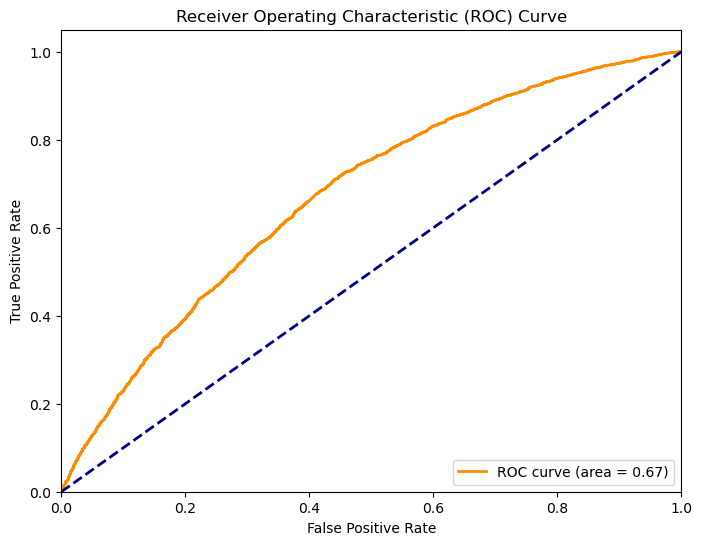

In [29]:
# Generate predictions and true labels
all_probs = []
all_targets = []

with torch.no_grad():
    for data, target in valid_loader:
        outputs = movie_model(data)
        probs = torch.sigmoid(outputs).view(-1).cpu().numpy()  # Probabilities
        all_probs.extend(probs)
        all_targets.extend(target.view(-1).cpu().numpy())

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()